In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
def filter_csv_pandas(input_file, instrument_column, target_instrument):
    # Initialize an empty list to store the filtered chunks
    filtered_chunks = []

    # Iterate through the CSV file in chunks
    for chunk in pd.read_csv(input_file, chunksize=10000):
        # Filter rows where the instrument column has the value "A"
        if instrument_column in chunk.columns:
            filtered_chunk = chunk[chunk[instrument_column] == target_instrument]
            
            # If the filtered chunk is not empty, add it to our list
            if not filtered_chunk.empty:
                filtered_chunks.append(filtered_chunk)
    
    # Concatenate all filtered chunks into a single DataFrame
    if filtered_chunks:
        return pd.concat(filtered_chunks, ignore_index=True)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no matching rows found


time = "2024-09-27_03:27" # EUR_USD_M15 - AUD_CAD_M15
time = "2024-09-27_03:35" # EUR_GBP_M15 - EUR_CAD_M15
time = "2024-12-12_12:01"
time = "2024-12-12_14:03"
time = "2024-12-12_15:48"


raw_df = filter_csv_pandas(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv", "instrument", "EUR_CAD_M15")

raw_df

,window,train_actual_return,train_num_trades,train_direction,test_actual_return,test_num_trades,test_direction,train_average_return,train_sharpe_ratio,train_profit_factor,...,total_windows,reverse_test,num_clusters,clustering_algorithm,train_period,test_period,random_seed,instrument,num_perceptually_important_points,price_history_length
0,1,0.048831,63,short,-0.001077,8,long,0.064130,1.823379,1000.0,...,197,True,8,kmeans,8,1,2,EUR_CAD_M15,4,24
1,2,0.044609,73,short,0.000095,13,long,0.064130,1.823379,1000.0,...,197,True,8,kmeans,8,1,2,EUR_CAD_M15,4,24
2,3,0.065501,90,short,0.018343,7,long,0.064130,1.823379,1000.0,...,197,True,8,kmeans,8,1,2,EUR_CAD_M15,4,24
3,4,0.028576,55,short,-0.000967,2,long,0.064130,1.823379,1000.0,...,197,True,8,kmeans,8,1,2,EUR_CAD_M15,4,24
4,5,0.021400,58,short,0.006603,7,long,0.064130,1.823379,1000.0,...,197,True,8,kmeans,8,1,2,EUR_CAD_M15,4,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105405,196,0.182783,266,long,-0.033410,24,short,0.128827,1.929035,1000.0,...,136,True,4,kmeans,12,1,2,EUR_CAD_M15,4,24
105406,197,0.187479,207,long,0.033421,31,short,0.128827,1.929035,1000.0,...,136,True,4,kmeans,12,1,2,EUR_CAD_M15,4,24
105407,198,0.123369,207,long,-0.026351,7,short,0.128827,1.929035,1000.0,...,136,True,4,kmeans,12,1,2,EUR_CAD_M15,4,24
105408,199,0.165166,196,long,-0.004503,17,short,0.128827,1.929035,1000.0,...,136,True,4,kmeans,12,1,2,EUR_CAD_M15,4,24


In [31]:
def find_best_combinations(raw_df, min_profit_factor=1.2, min_sharpe=0.1, min_trades=10):
    # Group by parameters except instrument and random_seed
    group_cols = ['num_clusters', 'clustering_algorithm', 'train_period', 
                 'test_period', 'reverse_test']
    
    # Calculate mean metrics across instruments and seeds
    param_performance = raw_df.groupby(group_cols).agg({
        'test_profit_factor': 'mean',
        'test_sharpe_ratio': 'mean',
        'test_win_ratio': 'mean',
        'test_num_trades': 'mean',
        'test_avg_trades_per_window': 'mean'
    }).reset_index()
    
    # Filter for minimum performance thresholds
    qualified_params = param_performance[
        (param_performance['test_profit_factor'] >= min_profit_factor) &
        (param_performance['test_sharpe_ratio'] >= min_sharpe) &
        (param_performance['test_avg_trades_per_window'] >= min_trades)
    ].copy()
    
    if len(qualified_params) == 0:
        print("No combinations meet the minimum criteria. Consider adjusting thresholds.")
        return None
    
    # Create a combined score with trade frequency consideration
    qualified_params['combined_score'] = (
        qualified_params['test_profit_factor'] * 0.4 +
        qualified_params['test_sharpe_ratio'] * 0.4 +
        (qualified_params['test_avg_trades_per_window'] / 
         qualified_params['test_avg_trades_per_window'].max()) * 0.2
    )
    
    # Sort by combined score
    best_params = qualified_params.sort_values('combined_score', ascending=False)
    
    # Get unique top combinations
    top_params = best_params.head(5)
    print(raw_df['instrument'].unique()[0])
    print("Top 5 Parameter Combinations:")
    print("-" * 50)
    for _, row in top_params.iterrows():
        print(f"\nCombination Details:")
        print(f"Clusters: {row['num_clusters']}")
        print(f"Algorithm: {row['clustering_algorithm']}")
        print(f"Train Period: {row['train_period']} weeks")
        print(f"Reverse Test: {row['reverse_test']}")
        
        print(f"Performance Metrics:")
        print(f"- Profit Factor: {row['test_profit_factor']:.3f}")
        print(f"- Sharpe Ratio: {row['test_sharpe_ratio']:.3f}")
        print(f"- Win Ratio: {row['test_win_ratio']:.3f}")
        print(f"- Avg Trades per Window: {row['test_avg_trades_per_window']:.1f}")
        print(f"- Combined Score: {row['combined_score']:.3f}")
        
    
    return best_params

find_best_combinations(raw_df)

EUR_CAD_M15
Top 5 Parameter Combinations:
--------------------------------------------------

Combination Details:
Clusters: 6
Algorithm: kmeans
Train Period: 5 weeks
Reverse Test: True
Performance Metrics:
- Profit Factor: 1.791
- Sharpe Ratio: 0.196
- Win Ratio: 0.578
- Avg Trades per Window: 13.3
- Combined Score: 0.928

Combination Details:
Clusters: 4
Algorithm: birch
Train Period: 14 weeks
Reverse Test: True
Performance Metrics:
- Profit Factor: 1.619
- Sharpe Ratio: 0.171
- Win Ratio: 0.598
- Avg Trades per Window: 19.4
- Combined Score: 0.910

Combination Details:
Clusters: 4
Algorithm: kmeans
Train Period: 14 weeks
Reverse Test: True
Performance Metrics:
- Profit Factor: 1.473
- Sharpe Ratio: 0.147
- Win Ratio: 0.510
- Avg Trades per Window: 20.0
- Combined Score: 0.848

Combination Details:
Clusters: 4
Algorithm: kmeans
Train Period: 12 weeks
Reverse Test: True
Performance Metrics:
- Profit Factor: 1.448
- Sharpe Ratio: 0.141
- Win Ratio: 0.555
- Avg Trades per Window: 19.7
-

,num_clusters,clustering_algorithm,train_period,test_period,reverse_test,test_profit_factor,test_sharpe_ratio,test_win_ratio,test_num_trades,test_avg_trades_per_window,combined_score
103,6,kmeans,5,1,True,1.790896,0.195806,0.577890,13.316583,13.316583,0.927624
19,4,birch,14,1,True,1.619144,0.171042,0.598485,19.386364,19.386364,0.909614
39,4,kmeans,14,1,True,1.473453,0.146867,0.510460,20.033473,20.033473,0.848128
37,4,kmeans,12,1,True,1.448419,0.140759,0.555147,19.669118,19.669118,0.832034
31,4,kmeans,9,1,True,1.440117,0.137306,0.576052,19.184466,19.184466,0.822494
47,5,birch,7,1,True,1.546263,0.155733,0.594241,13.759162,13.759162,0.818160
157,7,kmeans,12,1,True,1.543929,0.150391,0.543127,11.142857,11.142857,0.788970
87,6,birch,7,1,True,1.531236,0.151745,0.615979,11.340206,11.340206,0.786405
67,5,kmeans,7,1,True,1.421392,0.127991,0.535809,16.209549,16.209549,0.781578
149,7,kmeans,8,1,True,1.512843,0.146192,0.548593,11.457801,11.457801,0.778001


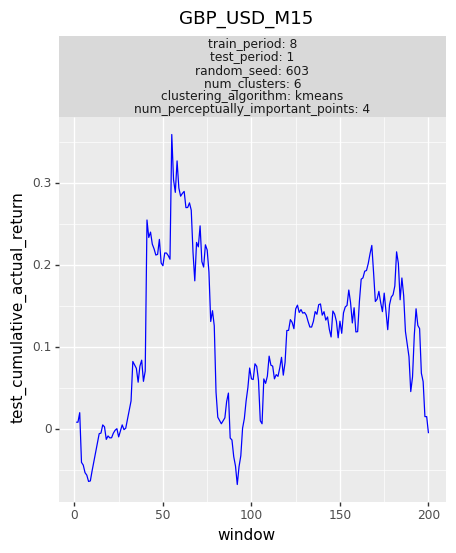

In [57]:
# Filter the dataframe by some dummy columns
# df = raw_df[(raw_df["clustering_algorithm"] == 'kmeans')]
# df = df[(df["num_clusters"] == 6)]
# df = df[(df["train_period"] == 8)]
# df = df[(df["price_history_length"] == 24)]
# df = df[(df["reverse_test"] == False)]

df = raw_df[(raw_df["clustering_algorithm"] == 'birch')]
df = df[(df["num_clusters"] == 10)]
df = df[(df["train_period"] == 5)]
df = df[(df["price_history_length"] == 24)]
df = df[(df["reverse_test"] == False)]

df["test_cumulative_actual_return"] = df["test_actual_return"].cumsum()

df
p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + num_perceptually_important_points", scales="free_x", labeller="label_both")
p = p + theme(figure_size=(5, 5))
# p = p + theme(figure_size=(35, 35))
instrument = df['instrument'].iloc[0]
algo = df['clustering_algorithm'].iloc[0]
p = p + ggtitle(instrument)
print(p)

In [ ]:
p = ggplot(raw_df)
p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + max_cluster_labels + num_perceptually_important_points", scales="free_x", labeller="label_both")
p = p + theme(figure_size=(5, 5))
# p = p + theme(figure_size=(35, 35))
instrument = df['instrument'].iloc[0]
algo = df['clustering_algorithm'].iloc[0]
p = p + ggtitle(instrument)
print(p)

In [ ]:
df = raw_df[(raw_df["test_sharpe_ratio"] >= 0.1) | (raw_df["test_inverse_sharpe_ratio"] >= 0.1)]

df

In [ ]:
# Filter the dataframe by some dummy columns
df = df[(df["clustering_algorithm"] == 'kmeans')]
df = df[(df["num_clusters"] == 90)]
df = df[(df["random_seed"] == 578)]
df = df[(df["train_period"] == 10)]
df = df[(df["num_perceptually_important_points"] == 5)]

In [ ]:
p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + max_cluster_labels + num_perceptually_important_points", scales="free_x", labeller="label_both")
p = p + theme(figure_size=(5, 5))
# p = p + theme(figure_size=(35, 35))
instrument = df['instrument'].iloc[0]
algo = df['clustering_algorithm'].iloc[0]
p = p + ggtitle(instrument)
print(p)

In [ ]:
output_path = f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/strategy_figures/{instrument}_{algo}.png"
# save the df
df.to_csv(output_path.replace(".png", ".csv"), index=False)
p.save(output_path, dpi=300)